In [48]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report
import matplotlib.pyplot as plt
from preprocessing import load_and_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


In [49]:
#Preprocessing function for all methods
X_train, X_test,y_train, y_test = load_and_split('data/training_data_ht2025.csv')

In [50]:
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, period):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X).astype(float).reshape(-1, 1)
        sin_feat = np.sin(2 * np.pi * X / self.period)
        cos_feat = np.cos(2 * np.pi * X / self.period)
        return np.hstack([sin_feat, cos_feat])
    
cyclical_cols = {
    'hour_of_day': 24,
    'day_of_week': 7,
    'month': 12
}
binary_cols = ['weekday', 'summertime', 'isRaining']

continuous_cols = [
    'temp', 'dew', 'humidity', 'snowdepth',
    'windspeed', 'cloudcover', 'visibility'
]
transformers = []

for col, period in cyclical_cols.items():
    transformers.append(
        (f"cyc_{col}", CyclicalEncoder(period=period), [col])
    )

transformers.append(("binary", "passthrough", binary_cols))
transformers.append(("continuous", "passthrough", continuous_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

In [51]:
param_grid = [
    {
        'scaler': [StandardScaler()],
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
        'clf__C': np.arange(0.0001,100,15),
        'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]

    },
    {
        'scaler': [StandardScaler()],
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l2'],  
        'clf__C': np.arange(0.0001,100,15),
        'clf__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]

    }
]

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=2137, max_iter=2000))
])

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=23) 

In [60]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv_strategy, 
    scoring='f1',
    verbose=0,
    n_jobs=-1 
)
grid_search.fit(X_train, y_train)

# --- 5. Retrieve the Best Results ---
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best CV Score (F1): {grid_search.best_score_:.4f}")

# --- 6. Final Model Evaluation ---
# The best estimator is the model trained with the best parameters on all of X_train.
best_model = grid_search.best_estimator_

Best Hyperparameters: {'clf__C': np.float64(30.0001), 'clf__class_weight': {0: 1, 1: 2}, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'scaler': StandardScaler()}
Best CV Score (F1): 0.6669


In [61]:
y_pred_test = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_test)
final_accuracy

0.8375

In [62]:
from sklearn.metrics import roc_auc_score,RocCurveDisplay,confusion_matrix,ConfusionMatrixDisplay

In [55]:
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = best_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_proba)

cm = confusion_matrix(y_pred=y_pred,y_true=y_test)

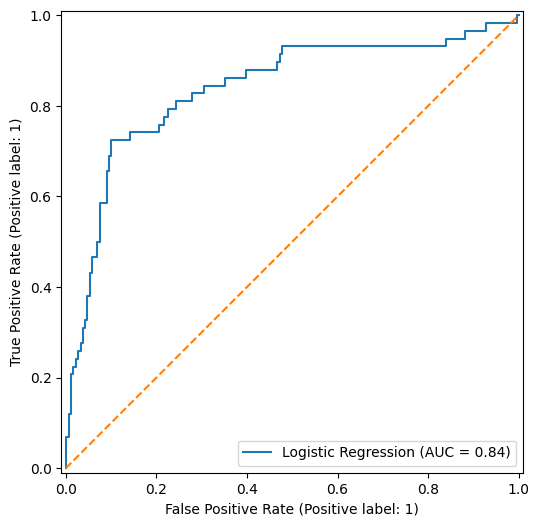

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
roc_display = RocCurveDisplay.from_estimator(
    best_model,         # Your final fitted model
    X_test,             # Test features
    y_test,             # True test labels
    name='Logistic Regression',
    ax=ax,              # Pass the axes object
)
ax.plot([0,1],[0,1], '--')

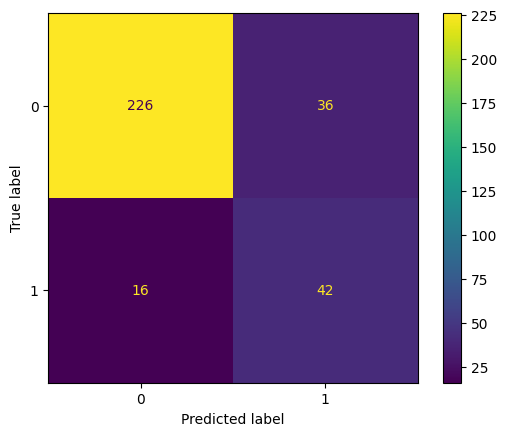

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot()

In [58]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test,y_pred, target_names=['low_bike_demand', 'high_bike_demand']))

                  precision    recall  f1-score   support

 low_bike_demand       0.93      0.86      0.90       262
high_bike_demand       0.54      0.72      0.62        58

        accuracy                           0.84       320
       macro avg       0.74      0.79      0.76       320
    weighted avg       0.86      0.84      0.85       320

